In [28]:
from sklearn.mixture import GMM
from sklearn import mixture
import pandas as pd
import numpy as np
import matplotlib
from collections import Counter
import scipy.stats as st
import itertools
from scipy import linalg

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df_oneSide=pd.read_csv('../data/bbContextOntopicRepliesOnlyDFtimeZone.csv',sep=';')

In [3]:
df_oneSide['dateObj']=pd.to_datetime(df_oneSide.date)

In [4]:
df_oneSide=df_oneSide.sort(['user_id','dateObj'])

-c:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


## Limit the data to the Analysis Window of 10/15/2012-11/23/2012

In [5]:
df_oneSide=df_oneSide[(df_oneSide.dateObj>=pd.to_datetime('2012-10-15 00:00:00')) & (df_oneSide.dateObj<pd.to_datetime('2012-11-24 00:00:00'))]

In [6]:
len(df_oneSide)

1576214

In [7]:
replies=df_oneSide[df_oneSide.replyWho!='0']

In [8]:
len(replies)

475092

In [9]:
grouped=df_oneSide.groupby('user_id')

In [10]:
df_oneSide['secDiff']=(grouped.dateObj.diff()).apply(lambda x: np.nan if pd.isnull(x) else x.value/(10**9))

In [11]:
np.max(df_oneSide.secDiff)

2850358.0

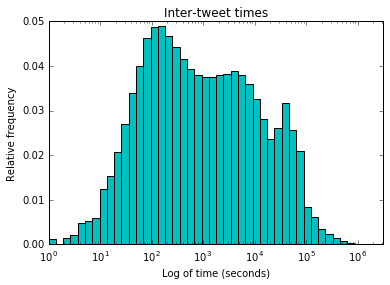

In [12]:
data = df_oneSide.secDiff.dropna().tolist()
bins=np.logspace(0, int(np.log(max(data))), 100)
width=bins[1:]-bins[:-1]
h, b=np.histogram(data,bins)
h=h/float(sum(h))
plt.figure()
plt.bar(b[:-1], h, width, color='c')
#plt.plot(bins[:-1], fit[:-1]*width, linewidth=2)
plt.gca().set_xscale("log")
plt.xlim(xmin=0,xmax=10**6.5)
plt.ylim(ymin=0, ymax=0.05)
plt.title("Inter-tweet times")
plt.xlabel('Log of time (seconds)')
plt.ylabel('Relative frequency')

In [13]:
np.log10(np.median(data))

2.8767949762007006

In [14]:
np.log10(max(data))

6.4548994100647441

In [15]:
len(df_oneSide[df_oneSide.secDiff!=0])

1573723

In [16]:
temp=np.log10(df_oneSide.secDiff[df_oneSide.secDiff!=0]).dropna()

In [17]:
max(temp)

6.4548994100647441

(0, 0.05)

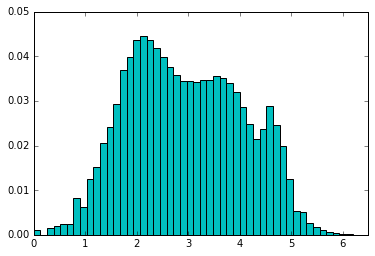

In [18]:
n=50
h, b=np.histogram(temp,n)
h=h/float(sum(h))
plt.figure()
plt.bar(b[:-1],h,max(temp)/float(n), color='c')
plt.xlim(xmin=0,xmax=6.5)
plt.ylim(ymin=0, ymax=0.05)

In [19]:
np.median(temp)

2.8796692056320534

In [20]:
logData=np.reshape(temp, (len(temp),1))

In [21]:
# fit models with 1-10 components
N = np.arange(1, 6)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GMM(N[i]).fit(logData)

/usr/local/lib/python3.4/dist-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multiva

In [23]:
# compute the AIC and the BIC
AIC = [m.aic(logData) for m in models]
BIC = [m.bic(logData) for m in models]

/usr/local/lib/python3.4/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_

In [24]:
M_best = models[np.argmin(AIC)]

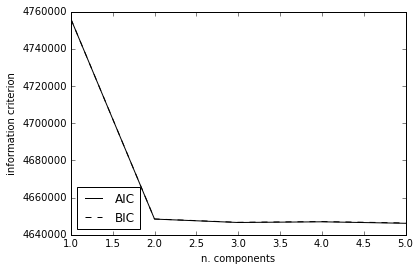

In [26]:
plt.plot(N, AIC, '-k', label='AIC')
plt.plot(N, BIC, '--k', label='BIC')
plt.xlabel('n. components')
plt.ylabel('information criterion')
plt.legend(loc=3)

In [27]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(logData)
        bic.append(gmm.bic(logData))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

NameError: name 'itertools' is not defined